In [33]:
import numpy as np
import glob
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import imageio

In [12]:
data_path = os.path.join(".", "data", "tracking_data")
image_files = sorted(glob.glob(data_path+"/*.jpg"))
gt_boxes_path = data_path + "/groundtruth.txt"
print("Number of images:", len(image_files))
print("GT bounding boxes:", gt_boxes_path)

Number of images: 252
GT bounding boxes: ./data/tracking_data/groundtruth.txt


In [124]:
with open(gt_boxes_path, "r") as f:
    gt_boxes = np.loadtxt(f, delimiter=',',dtype=np.float32)

images = [np.asarray(Image.open(image)) for image in image_files]

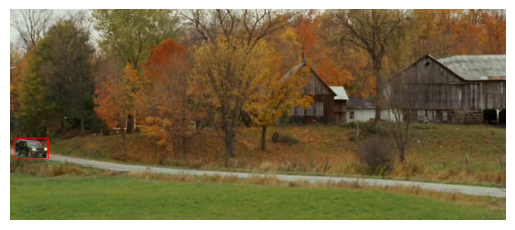

In [125]:
test_image = images[0].copy()
gt_box_test = gt_boxes[0].astype(np.int32)
tl_test = (gt_box_test[2], gt_box_test[3])
br_test = (gt_box_test[-2], gt_box_test[-1])
test_image_rect = cv2.rectangle(test_image.copy(), tl_test, br_test, color=(255,0,0))
plt.imshow(test_image_rect)
_ = plt.axis('off')

In [35]:
tls = [(box[2], box[3]) for box in gt_boxes.astype(np.int32)]
brs = [(box[-2], box[-1]) for box in gt_boxes.astype(np.int32)]
gt_seq = [cv2.rectangle(img, tl, br, color=(255,0,0)) for img,tl,br in zip(images, tls, brs)]
imageio.mimsave("gt_seq.gif", gt_seq, loop=0)


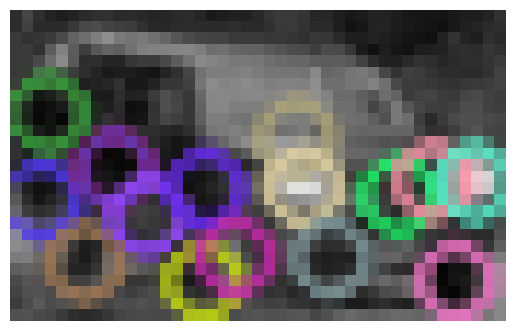

In [178]:
template_img = test_image[tl_test[1]:br_test[1], tl_test[0]:br_test[0]]
_ = plt.axis('off')
_ = plt.imshow(template_img)
sift = cv2.SIFT_create()
test_gray = cv2.cvtColor(test_image.copy(), cv2.COLOR_BGR2GRAY)
template_img_gray = cv2.cvtColor(template_img.copy(), cv2.COLOR_BGR2GRAY)
kp1 = sift.detect(test_gray, None)
kp2 = sift.detect(template_img_gray, None)
sift_img1 = cv2.drawKeypoints(test_gray.copy(), kp1, test_image.copy())
sift_img2 = cv2.drawKeypoints(template_img_gray.copy(), kp2, template_img_gray.copy())
# plt.imshow(sift_img1)
plt.imshow(sift_img2)

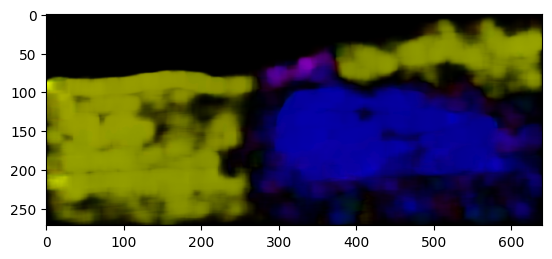

In [167]:
# dense optical flow
prev_img = cv2.cvtColor(images[0], cv2.COLOR_RGB2GRAY)
hsv = np.zeros_like(images[0])
hsv[..., 1] = 255
for i in range(1, len(image_files)):
    curr_img = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_img, curr_img, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    prev_img = curr_img
    plt.imshow(bgr)
    plt.imsave(f"results/dense_test_{i}.png", bgr)
    # time.sleep(.0)

In [193]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
 qualityLevel = 0.3,
 minDistance = 1,
 blockSize = 3 )
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize = (7, 7),
 maxLevel = 2,
 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
 
# Create some random colors
color = np.random.randint(0, 255, (1000, 3))
 
# Take first frame and find corners in it
old_gray = cv2.cvtColor(images[0].copy(), cv2.COLOR_BGR2GRAY)
gt_box = gt_boxes[0].astype(np.int32)
tl = (gt_box[2], gt_box[3])
br = (gt_box[-2], gt_box[-1])
w = br[0]-tl[0]
h = br[1]-tl[1]
feats = sift.detect(old_gray[tl[1]:br[1], tl[0]:br[0]], None)
# px = cv2.goodFeaturesToTrack(old_gray[tl[1]:br[1], tl[0]:br[0]], mask = None, **feature_params)

p0 = []
for f in feats:
    x = f.pt[0]+tl[0]
    y = f.pt[1]+tl[1]
    p0.append([x,y])
p0 = np.array(p0)[:,None,:].astype(np.float32)
 
# Create a mask image for drawing purposes
mask = np.zeros_like(images[0])
 
lk_seq = []
for j in range(1, len(image_files)):
# for j in range(1, 10):
    frame_gray = cv2.cvtColor(images[j], cv2.COLOR_RGB2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]

    # draw the tracks
    # for i, (new, old) in enumerate(zip(good_new, good_old)):
    #     a, b = new.ravel()
    #     c, d = old.ravel()
    #     mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
    #     frame = cv2.circle(images[j].copy(), (int(a), int(b)), 5, color[i].tolist(), -1)
    #     img = cv2.add(frame, mask)

    # draw rectangle
    x_med, y_med = np.median(good_new, axis=0).astype(np.int32)
    img = cv2.rectangle(images[j].copy(), (x_med-w//2, y_med-h//2), (x_med+w//2, y_med+h//2), color=(0,255,0))
    lk_seq.append(img)
    
    # plt.imshow(img)
    plt.imsave(f"results/lk/sparse_lk_test_{j}.png", img)

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    if j%20==0:
        gt_box = gt_boxes[j].astype(np.int32)
        tl = (gt_box[2], gt_box[3])
        br = (gt_box[-2], gt_box[-1])
        w = br[0]-tl[0]
        h = br[1]-tl[1]
        p0 = []
        feats = sift.detect(old_gray[tl[1]:br[1], tl[0]:br[0]], None)
        for f in feats:
            x = f.pt[0]+tl[0]
            y = f.pt[1]+tl[1]
            p0.append([x,y])
        p0 = np.array(p0)[:,None,:].astype(np.float32)
        mask = np.zeros_like(images[0])
        continue
        # p0 = cv2.goodFeaturesToTrack(old_gray[tl[1]:br[1], tl[0]:br[0]], mask = None, **feature_params)
    p0 = good_new.reshape(-1, 1, 2)

imageio.mimsave("results/lk_seq_reset20.gif", lk_seq, loop=0)